# Baseline: Reflex Control

Steers the car using a PD controller on the estimated $y_m$ track median offset.

In [50]:
from DriveItMultiGym import *
from car import *
import numpy as np
from numpy import pi

num_episodes = 1  # number of episodes to run
time_limit = 10.0
throttle_limit = 0.75
gamma = 0.995
epsilon = 0.1
kp, kv = 1.0, 0.3
random_position=True

cars = [Car(Color.black), Car(Color.green), Car(Color.pink)]
env = DriveItEnv(cars, time_limit, gamma)
observations = env._reset(random_position)
ym_ = 0.0
done = False
reward_episode = 0
reward_sum = 0.0
crashes = 0

for i_episode in range(1, num_episodes + 1):
    while not done:
        if num_episodes < 2 and time_limit < 60.0:
            env.render()

        actions = []
        for o in observations:
            xm, ym, theta, steer, v = o
            dym = ym - ym_
            ym_ = ym
            f = steer + kp * ym + kv * dym / dt
            if f > epsilon: action = 2
            elif f < -epsilon: action = 1
            else: action = 0

            if v < 2.5:
                action += 3
            
            actions.append(action)

        observations, rewards, done, info = env.step(actions)
        #reward_episode += reward
        #reward_sum = reward + gamma * reward_sum

    if num_episodes <= 10:
        print('Episode %d %s. reward: %f, laps: %f' % \
              (i_episode, info['done'], reward_episode, \
               reward_episode / lap_median_length))

    if info['done'] != 'complete':
        crashes += 1

    reward_sum += reward_episode
    reward_episode = 0
    observation = env._reset(random_position)
    done = False

if num_episodes > 1:
    print('Average reward: %f with %d crashes' % \
          (reward_sum / num_episodes, crashes))

Episode 1 complete. reward: 0.000000, laps: 0.000000


In [2]:
env.close()

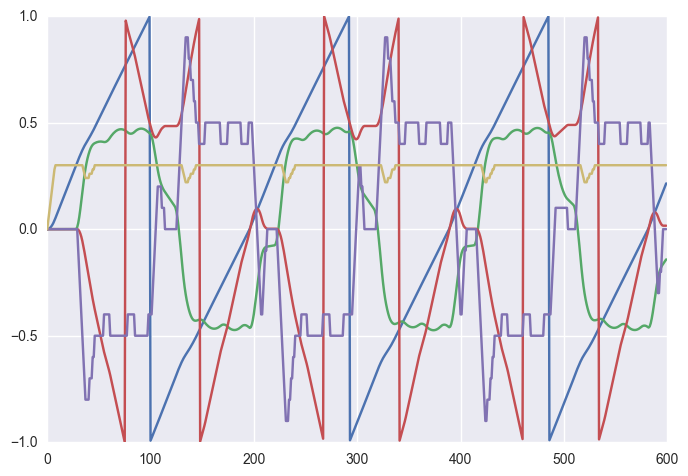

In [10]:
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
style.use('ggplot')
%matplotlib inline
sns.set()
y = plt.plot([o for o in obs])
#plt.xlabel('time');plt.ylabel('error')

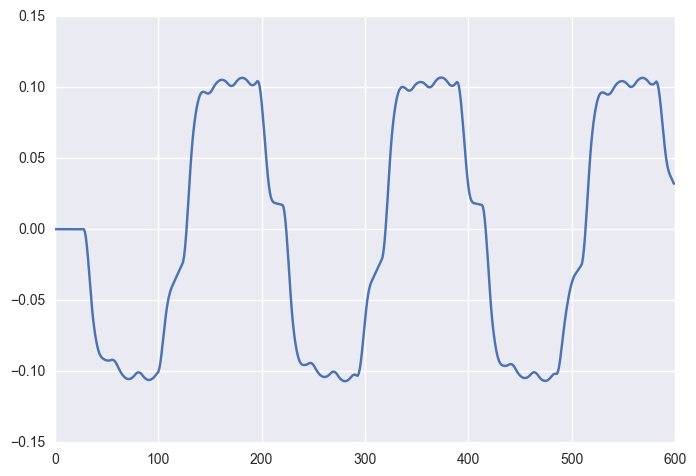

In [5]:
i = 1
y = plt.plot([e[i] if abs(e[i])<1.0 else 0 for e in err])
#plt.plot([o[i] for o in obs])

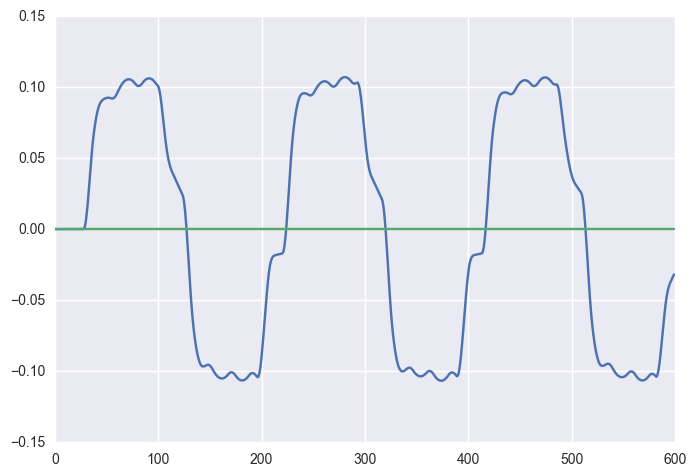

In [6]:
y = plt.plot([p[i] for p in pos])
y = plt.plot([o[i] for o in obs])

In [55]:
env._reset(random_position)

[array([-1.38216417,  0.        ,  2.61452647,  0.49259259,  0.        ]),
 array([-0.10913537,  0.        , -0.28026446,  0.59259259,  0.        ]),
 array([ 0.28992922,  0.        , -0.0108824 ,  0.        ,  0.        ])]

In [56]:
env.render()

In [22]:
# out penalty = max discounted reward for median laps at full speed
rmax = throttle_limit * v_max * dt / (1 - gamma)
rmax

2.0833333333333313

In [9]:
from filter import *
f = LowPassFilter(np.array([0.8, 0.5, 0.0, 0.3, 0.7]), np.array([1.0, 2, 3, 4, 5]))
f.filter([1,2,3,4,5])

array([ 1.,  2.,  3.,  4.,  5.])

In [26]:
f.filter([1,2,3,4,5])

array([ 1.        ,  4.66601562,  3.        ,  4.        ,  5.        ])

In [27]:
f.filter([1,10,10,4,5])

array([  1.        ,   7.33300781,  10.        ,   4.        ,   5.        ])

In [2]:
import numpy as np
g = 2.0
i = np.array([1.0, 2.0])
o = np.ones_like(i)
i * g

array([ 2.,  4.])

In [7]:
import numpy as np
gain = 0.85
initial_value = 0.0
feedback_gain = np.ones_like(initial_value) * gain
output_gain = 1.0 - feedback_gain
output = initial_value
feedback_value = initial_value / output_gain


In [ ]:
def plop(feedback_gain, initial_value=np.array([0.0])):
    feedback_gain = np.ones_like(initial_value) * feedback_gain
    print(feedback_gain)
plop(0.85)

In [8]:
from car import *
#c1 = Car()
c1 = Car(theta=pi/2)
d, alpha = c1.distance(-0.7, 0.7)
print(c1.state)
(d, alpha / pi * 180.)

(0.0, 0.0, 1.5707963267948966, 0.0, 0.0, 0.0, 0.0)


(0.90509667991878073, 45.0)

In [5]:
math.atan2(.12, .24)/pi*180

26.565051177077986

In [8]:
math.sin(pi)

1.2246467991473532e-16